In [29]:
import os
import json

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib notebook

In [121]:
import wandb
from wandb.keras import WandbCallback

# 1. Start a new run
wandb.init(project='offline-rl', entity='deathn0t')

epoch,99
loss,1.10981
acc,0.47015
val_loss,1.16474
val_acc,0.41751
_runtime,1633
_timestamp,1615307282
_step,199
best_val_loss,1.16474
best_epoch,99


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
loss,████████████████████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇▇▇▇▇▇█████████████
val_loss,████████████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▇▇█████████▇█▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂████████████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [4]:
# load the data

file_name = "polynome_ready_for_training.json"

with open(file_name, "r") as f:
    data = json.load(f)
    
print("keys: ", list(data.keys()))

keys:  ['states', 'actions', 'scores']


In [107]:
# keep only winning networks

X, y = [], []

n_networks = len(np.unique(data["actions"]))
n_func = len(data["states"]) // n_networks
print(n_networks, n_func)

for f_i in range(n_func):

    best_network = None
    best_score = -2
    
    for n_i in range(n_networks):

        i = f_i * n_networks + n_i

        score = data["scores"][i]
        if score > best_score:
            best_score = score
            best_network = data["actions"][i]
    
    X.append(data["states"][i])
    y.append(best_network)
    
X = np.array(X)
y = np.array(y)

5 900


In [104]:
# sanity check

for i in range(6):
    print(X[i][:5], y[i])
    
print(np.bincount(y))

[-0.61616162 -0.6969697  -0.97979798  0.81818182  0.29292929] 0
[ 0.83838384  0.23232323  0.75757576 -0.97979798 -0.47474747] 1
[-1.         -0.83838384  0.67676768  0.37373737  0.87878788] 1
[ 0.17171717 -0.85858586  0.91919192 -0.7979798  -0.07070707] 0
[ 0.31313131  0.61616162  0.87878788  0.77777778 -0.95959596] 0
[ 0.37373737 -1.         -0.5959596  -0.67676768  1.        ] 2
[325 288 255  24   8]


In [109]:
if y.shape[1] == 1:
    y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (900, 160)
y shape:  (900, 5)


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, 
    random_state=42
)

In [129]:
# Creation of the model

def generate_nn(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
        model.add(tf.keras.layers.BatchNormalization())
        model.add(
            tf.keras.layers.Dense(nunits_, activation=activation_, name=f"layer_{i+1}")
        )

    model.add(tf.keras.layers.Dense(output_shape, activation="softmax"))

    return model

nlayers = 3
config = dict(
    nunits=[100]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 160)               640       
_________________________________________________________________
layer_1 (Dense)              (None, 100)               16100     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
layer_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
layer_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 5)               

In [112]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1
).history

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 1.4981 - acc: 0.3045 - val_loss: 1.2320 - val_acc: 0.3300
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0943 - acc: 0.5101 - val_loss: 1.2307 - val_acc: 0.3434
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9719 - acc: 0.6422 - val_loss: 1.2944 - val_acc: 0.3603
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 0.7832 - acc: 0.7551 - val_loss: 1.3741 - val_acc: 0.3333
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.5944 - acc: 0.8321 - val_loss: 1.5387 - val_acc: 0.3906
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 0.4175 - acc: 0.8762 - val_loss: 1.7236 - val_acc: 0.3805
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.2252 - acc: 0.9533 - val_loss: 2.0397 - val_acc: 0.3300
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1472 - a

38/38 [==============================] - 0s 2ms/step - loss: 1.0891e-04 - acc: 1.0000 - val_loss: 5.3045 - val_acc: 0.3434
Epoch 63/100
38/38 [==============================] - 0s 2ms/step - loss: 1.0561e-04 - acc: 1.0000 - val_loss: 5.3230 - val_acc: 0.3434
Epoch 64/100
38/38 [==============================] - 0s 2ms/step - loss: 1.0239e-04 - acc: 1.0000 - val_loss: 5.3429 - val_acc: 0.3434
Epoch 65/100
38/38 [==============================] - 0s 2ms/step - loss: 9.7909e-05 - acc: 1.0000 - val_loss: 5.3606 - val_acc: 0.3468
Epoch 66/100
38/38 [==============================] - 0s 2ms/step - loss: 1.0235e-04 - acc: 1.0000 - val_loss: 5.3807 - val_acc: 0.3434
Epoch 67/100
38/38 [==============================] - 0s 2ms/step - loss: 9.7583e-05 - acc: 1.0000 - val_loss: 5.3993 - val_acc: 0.3468
Epoch 68/100
38/38 [==============================] - 0s 2ms/step - loss: 9.0746e-05 - acc: 1.0000 - val_loss: 5.4175 - val_acc: 0.3468
Epoch 69/100
38/38 [==============================] - 0s 2ms/

<IPython.core.display.Javascript object>


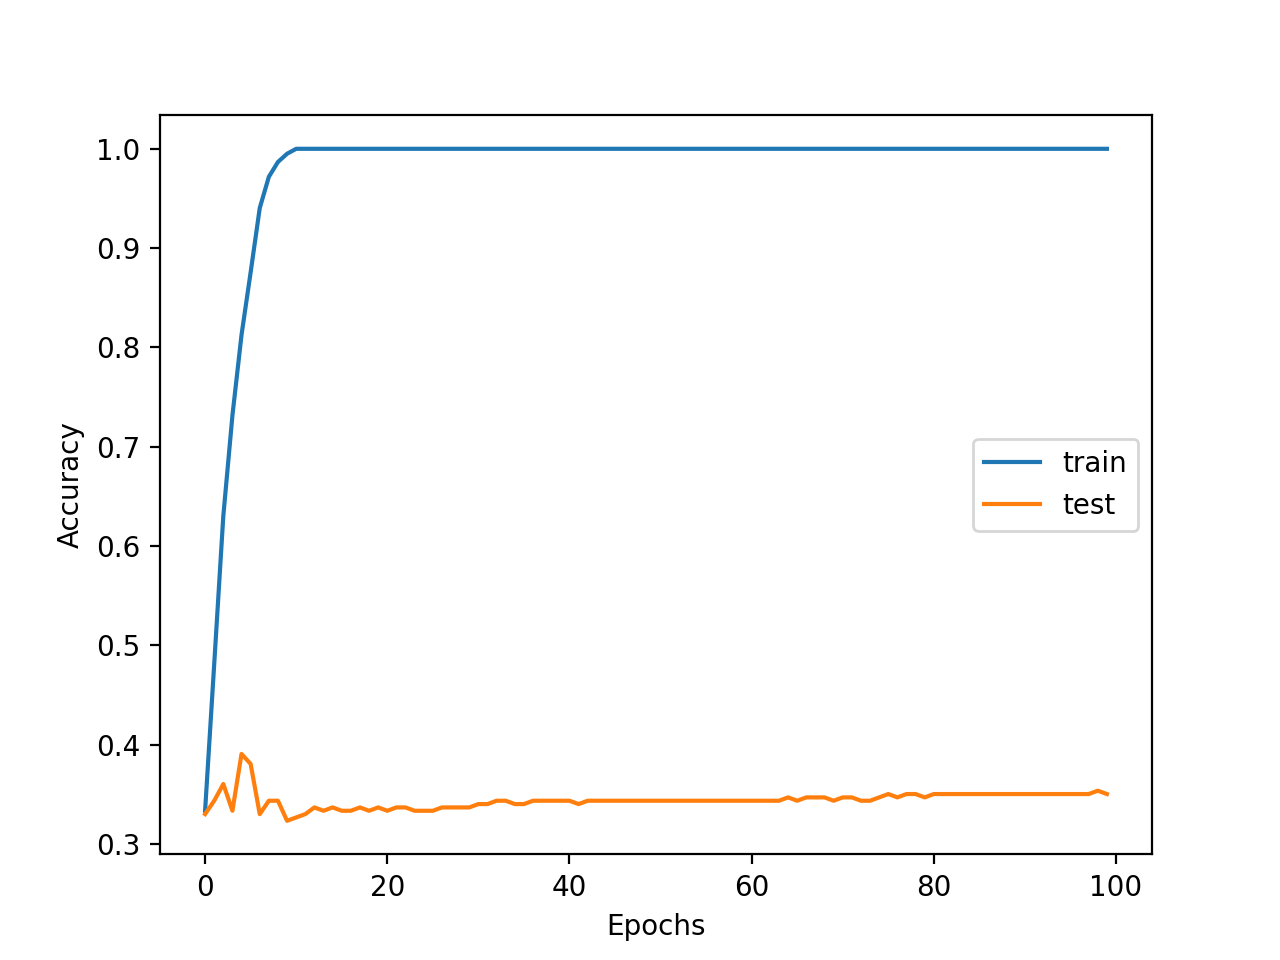

In [113]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


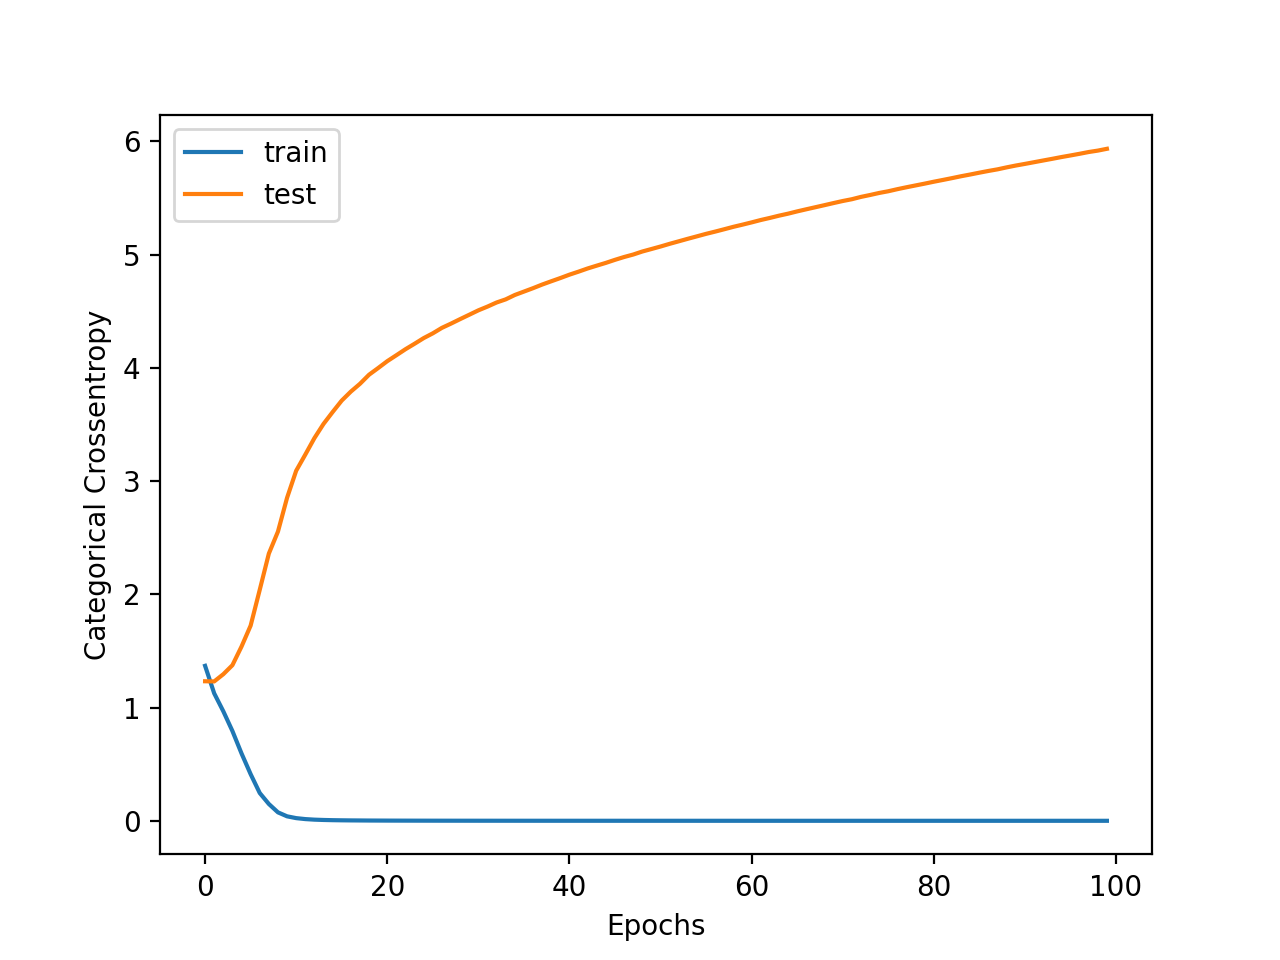

In [114]:
plt.figure()
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")

plt.legend()

plt.show()

In [115]:
# with augmentation (permutations)

def augment(x, y):
    indexes = tf.range(80, delta=1)
    indexes = tf.random.shuffle(indexes)
    x = tf.concat([tf.gather(x, indexes), tf.gather(x, indexes+80)], axis=0)
    return x, y

tf_data = tf.data.Dataset.from_tensor_slices((X,y))
tf_data = tf_data.map(augment)

def sanity_check():
    for xi, yi in tf_data.as_numpy_iterator():
        print(xi[:5], yi)
        break
    for xi, yi in tf_data.as_numpy_iterator():
        print(xi[:5], yi)
        break
sanity_check()

[ 1.         -0.67676768  0.8989899  -0.25252525  0.05050505] [1. 0. 0. 0. 0.]
[-0.63636364  0.43434343 -0.35353535 -1.         -0.23232323] [1. 0. 0. 0. 0.]


In [132]:
batch_size = 32
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_train = tf_train.shuffle(1000).repeat(100)
tf_train = tf_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
tf_train = tf_train.batch(batch_size)
tf_train = tf_train.prefetch(tf.data.AUTOTUNE)

In [128]:
nlayers = 3
config = dict(
    nunits=[10]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 10)                1610      
_________________________________________________________________
layer_2 (Dense)              (None, 10)                110       
_________________________________________________________________
layer_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 55        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [124]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))

class_weight = {i:v for i,v in enumerate(class_weights)}

print(class_weight)

{0: 0.5538461538461539, 1: 0.625, 2: 0.7058823529411765, 3: 7.5, 4: 22.5}


In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(tf_train,
    epochs=100, 
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[WandbCallback()],
    class_weight=class_weight
).history

Epoch 1/100
1885/1885 [==============================] - 5s 2ms/step - loss: 1.0689 - acc: 0.3457 - val_loss: 1.5650 - val_acc: 0.2593
Epoch 2/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0568 - acc: 0.3518 - val_loss: 1.5996 - val_acc: 0.2626
Epoch 3/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0694 - acc: 0.3568 - val_loss: 1.6369 - val_acc: 0.2458
Epoch 4/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0596 - acc: 0.3636 - val_loss: 1.6688 - val_acc: 0.2155
Epoch 5/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0469 - acc: 0.3603 - val_loss: 1.6480 - val_acc: 0.2559
Epoch 6/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0384 - acc: 0.3658 - val_loss: 1.6165 - val_acc: 0.2525
Epoch 7/100
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0524 - acc: 0.3618 - val_loss: 1.5963 - val_acc: 0.2795
Epoch 8/100
1885/1885 [==============================] 

<IPython.core.display.Javascript object>


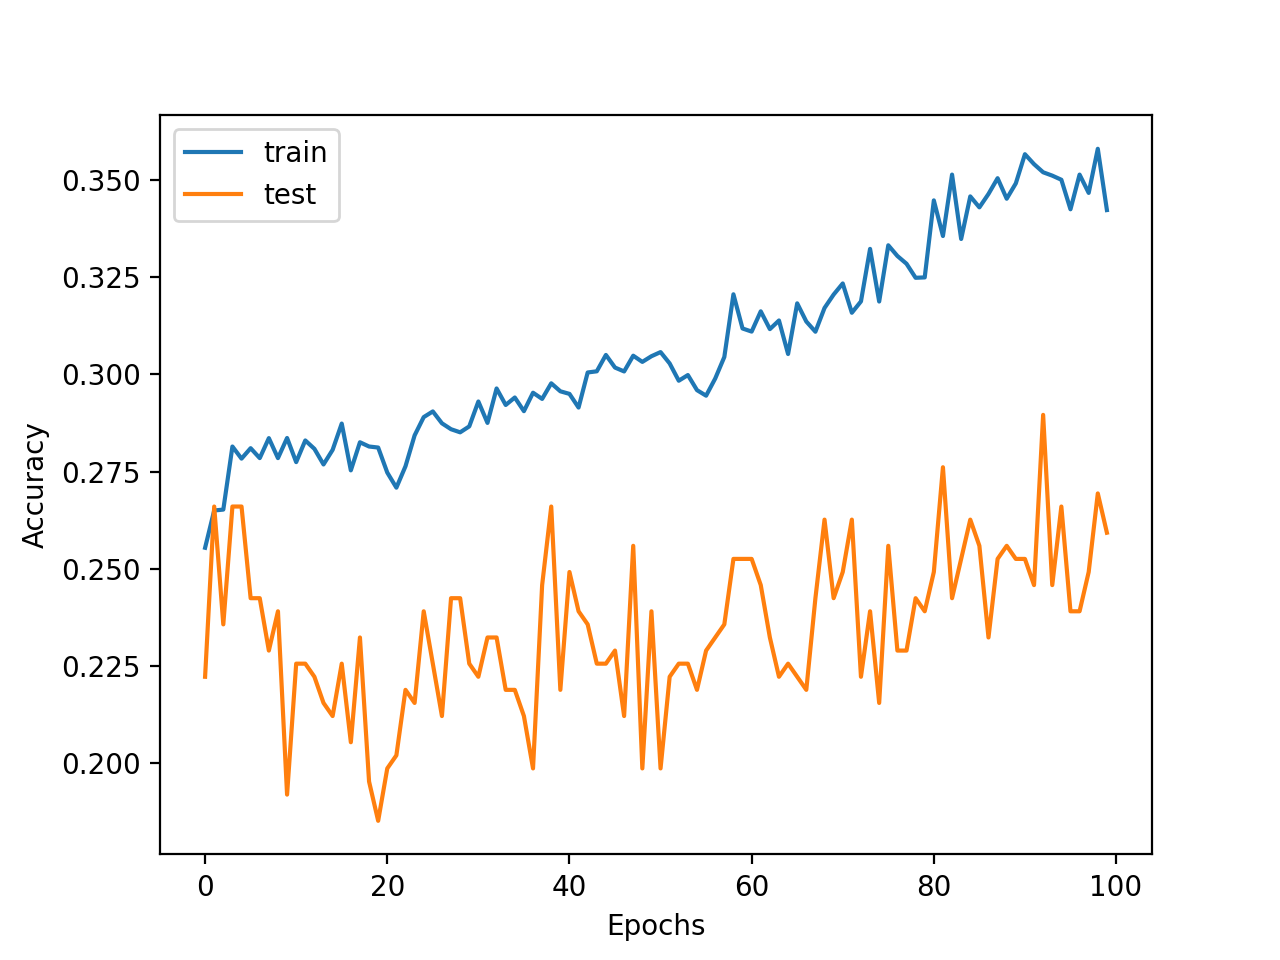

In [131]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Balanced Accuracy")

plt.legend()

plt.show()